In [525]:
from scipy.optimize import fsolve # Used for solving a system of #K non-linear equations with #K unknows: Used for calibrating the price elastic demand
import scipy.interpolate as interpolate
import scipy.stats as stats
# If you experience warning of the type "Future Warning", you can mute them using the following:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

*Import the standard packages and data:*

In [132]:
%run stdPackages.ipynb
slides = False # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'mBasicInt_StorageExperiment.xlsx'), read)
readSets(db)

# Economic and welfare effects from storage

### 1. Start by setting up and solving the model with perfectly inelastic demand:*

In [133]:
m = mBasicInt.mSimple(db.copy())
m.solve()
db_base = m.db.copy()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


### 2. Plot merit order curve for each hour:

In [134]:
def demand_h(m,h):
    return standardPlots.demandLinear_df(m.db['MWP_LoadShedding'], m.hourlyLoad.xs(h))
def supply_h(m,h,maxY=30):
    return standardPlots.meritOrderCurve_df(m.db['mc'], m.hourlyGeneratingCapacity.xs(h,level='h'),maxY=maxY)

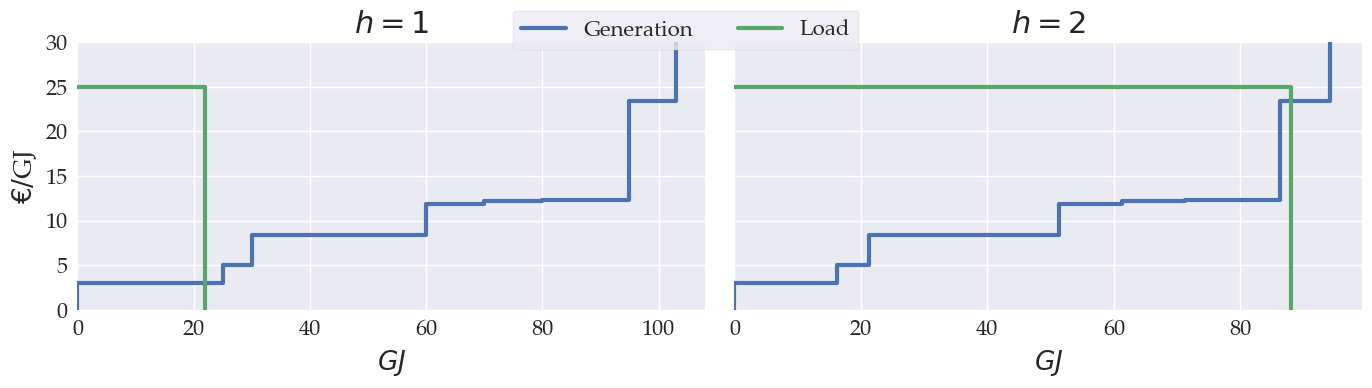

In [308]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    df = supply_h(m,h)
    dh = demand_h(m,h)
    
    df.plot(linewidth=3,ax=ax,legend=False);
    dh.plot(linewidth=3,ax=ax,legend=False);
    ax.set_xlabel(r'$GJ$', labelpad = 5);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(['Generation', 'Load'],loc=9,ncol=2,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_MeritOrder_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_MeritOrder.pdf",edgecolor='k')

### 2. Plot marginal fuel consumption and CO2 emissions for each hour:

*Functions for making database:*

In [6]:
def other_from_supply(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='c')
    df = df[df['q']>0]
    df['q'] = df['q'].cumsum()
    df_up = df.copy()
    df_up['q'] = df_up['q']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('q').set_index('q')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

def other_from_prices(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='q')
    df_up = df.copy()
    df_up['c'] = df_up['c']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('c').set_index('c')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

*Plot marginal emissions:*

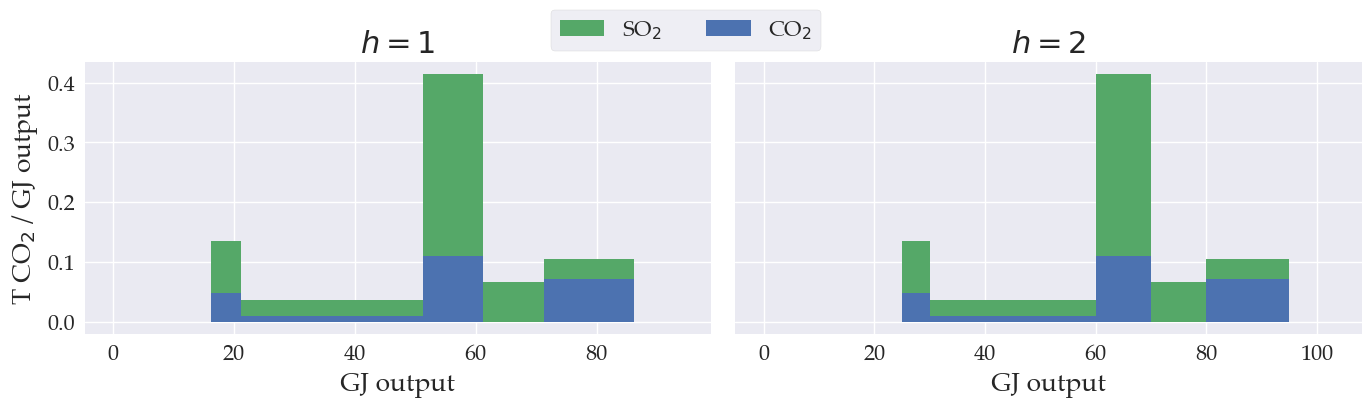

In [7]:
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= mBasicInt.plantEmissionIntensity(m.db).unstack('EmissionType'))
    # df = other_from_prices(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= mBasicInt.plantEmissionIntensity(m.db).unstack('EmissionType'))
    h = j+1
    
    df.plot(kind='area',linewidth=0,ax=ax,legend=False,stacked=True);
    ax.set_ylabel(r'T CO$_2$ / GJ output', labelpad = 5);
    ax.set_xlabel(r'GJ output', labelpad = 5);
    # ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    # ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")

# fig.legend(['CO$_2$', 'SO$_2$'],loc=9,ncol=2,frameon=True)
legend_elements = [mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='SO$_2$'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='CO$_2$')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Emissions_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Emissions.pdf",edgecolor='k')

*Plot marginal fuel conumpstion:*

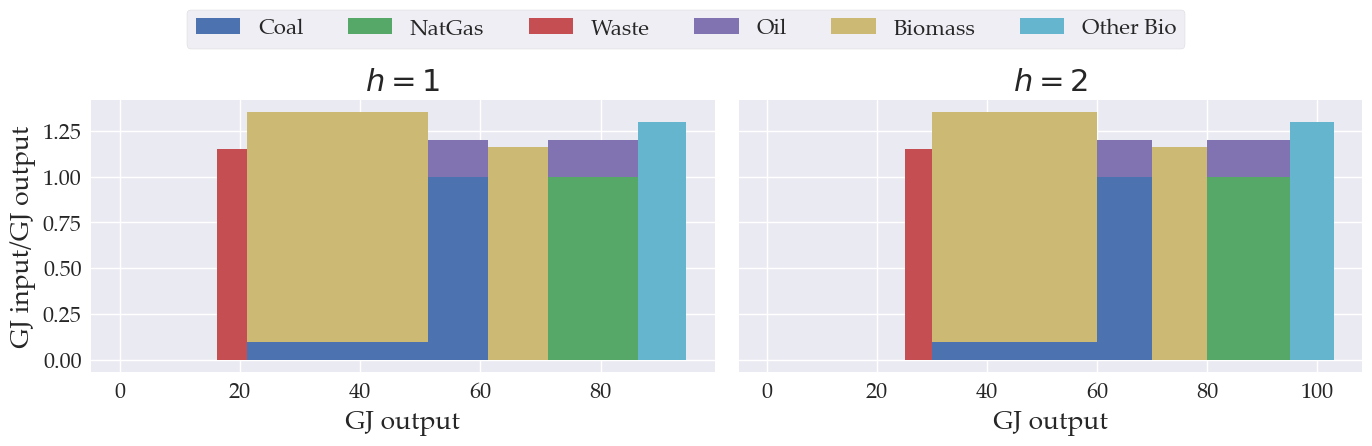

In [8]:
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
    # df = other_from_prices(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
    agg_cols = {'Oil':['Fueloil','Gasoil'], 'Biomass':['Straw','WoodPellets','WoodChips','WoodWaste'],'Other Bio':['Biogas','BioOil']}
    for col in agg_cols.keys():
        df[col] = df[agg_cols[col]].sum(axis=1)
    df.drop(columns=[item for sublist in list(agg_cols.values()) for item in sublist],inplace=True) 

    h = j+1
    
    df.plot(kind='area',linewidth=0,ax=ax,legend=False,stacked=True);
    ax.set_ylabel(r'GJ input/GJ output', labelpad = 5);
    ax.set_xlabel(r'GJ output', labelpad = 5);
    # ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    # ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")

# fig.legend(['CO$_2$', 'SO$_2$'],loc=9,ncol=2,frameon=True)
fuels = df.columns
legend_elements = [mpl.patches.Patch(facecolor=colors[x], edgecolor=None, label=fuels[x]) for x in range(len(fuels))]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(fuels), frameon=True, bbox_to_anchor=(0.5, 1))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_FuelConsumption_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_FuelConsumption.pdf",edgecolor='k')

### 2. Model with flexible demand

*Get the basic parameters of the model:*

In [9]:
pj_ini = m.db['marginalSystemCosts'].values # Hourly prices
E_ini = m.db['Load'].astype(float).values[0] # Yearly demand
Ej_ini = m.db['LoadVariation'].astype(float).values*E_ini # Hourly demand
I = sum(Ej_ini*pj_ini) # Total expenditures=Income
Exp = sum(m.db['HourlyDemand'].values*pj_ini)
p_ini = I/E_ini # Iniatal yearly price index

*Create loop on storage level:*

In [10]:
loop = pd.Index(range(10), name = 'loop')

In [11]:
λ = 0.2
# Off-peak grid
v0 = pd.Series(db['LoadVariation'].min(), index = pd.Index(['c1'], name = 'c')) # 'id4' is the wind plant
vT = pd.Series(0.40, index = pd.Index(['c1'], name = 'c'))
OffPeakGrid = addGrid(v0, vT, loop, 'LoadVariation')# inputs are (1) first value in grid, (2) final value, (3) loop, (4) name of symbol
OffPeakGrid.index = pd.MultiIndex.from_tuples([(a[0],a[1],1) for a in OffPeakGrid.index], names=OffPeakGrid.index.names+['h'])

# Peak grid
step = OffPeakGrid.diff().fillna(0)
S0_grid = (step.cumsum()*db['Load']).astype(float).values
PeakGrid = pd.Series([db['LoadVariation'].max()-(1-λ)*s[-1]*s[0][0] for s in step.iteritems()],index=OffPeakGrid.rename({1:2},level='h').index,name='LoadVariation').sort_index()

# Common grid
LoadVariationGrid = OffPeakGrid.append(PeakGrid).sort_index()

*Update MWP for loadshedding:*

In [12]:
m.db['MWP_LoadShedding'] = 1000
max_cap = m.hourlyGeneratingCapacity.astype(float).unstack('h').cumsum().max().values-1

*Specify functions for CES demand:*

In [13]:
f_pCES = lambda μj,pj,σ: (μj[0]*pj[0]**(1-σ)+μj[1]*pj[1]**(1-σ))**(1/(1-σ)) if σ!=1 else (pj[0]**(μj[0])+pj[1]**(μj[1]))
f_qCES = lambda μj,pj,p,σ:  μj*(pj/p)**(-σ)*I/p
v_qCES = np.vectorize(f_qCES,excluded=['I','p'])

*Specify smooth supply:*

In [641]:
def kinked_supply(h,mc,production):
    production = production.xs(h,level='h')
    df = pd.concat({'price':mc,'supply':production},axis=1).sort_values(by='price').astype(float)
    df = df[df['supply']>0]
    df['supply'] = df['supply'].cumsum()
    df.loc[0,['price','supply']] = [0,0]
    q_max = df['supply'].nlargest(2)
    p_max = df['price'].nlargest(2)
    df.loc[len(df),['price','supply']] = [m.db['MWP_LoadShedding']*1.5,q_max.max()] #
    # Mid point horizontally
    df_h = df.sort_values(by='price').copy()
    df_h.loc[df_h.index.isin(m.db['id']),'supply'] = (df_h['supply'].values[:-2:1] + df_h['supply'].values[1:-1:1])/2
    # Mid point vertically
    df_v = df.sort_values(by='price').copy()
    df_v.loc[df_v.index.isin(m.db['id']),'price'] = (df_v['price'].values[:-2:1] + df_v['price'].values[1:-1:1])/2
    df_v['price'] = df_v['price'].shift(-1)
    # Combine
    df = df_h.append(df_v.dropna()).sort_values(by='price').drop_duplicates()
    df = df[(df['price']>0) & (df['price']!=df['price'].nlargest(2).min())]
    df.loc[len(df),['price','supply']] = [p_max.max()+4/5*(m.db['MWP_LoadShedding']-p_max.max()),q_max.min()+4/5*(q_max.max()-q_max.min())]
    df.loc[len(df),['price','supply']] = [p_max.max()-4/5*(m.db['MWP_LoadShedding']-p_max.max()),q_max.min()+1/5*(q_max.max()-q_max.min())]
    
    return df.set_index('supply')['price'].sort_index().astype(float)

def smooth_supply(p,*params):
    mc,q,σ_s = params
    return (q*stats.norm.cdf((p[:,np.newaxis]-mc)/σ_s)).sum(axis=1)
def d_smooth_supply(p,*params):
    mc,q,σ_s = params
    return (q*stats.norm.pdf((p.reshape(1,2)-mc[:,np.newaxis])/σ_s)/σ_s).sum(axis=0)
def demand(p,*params):
    μ,σ_d,I = params
    if σ_d!=1:
        p_index = ((μ*p)**(1-σ_d)).sum(axis=0)**(1/(1-σ_d))
    else:
        p_index = (p**(μ)).sum(axis=0)
    return μ*(p/p_index)**(-σ_d)*I/p_index
def d_p_index(p,*params):
    μ,σ_d,I = params
    if σ_d!=1:
        d_p_index = σ_d/(σ_d-1)*((μ*p)**(1-σ_d)).sum(axis=0)**(-1/σ_d)*μ*(1-σ_d)*p**(-σ_d)
    else:
        d_p_index = (μ*p**(μ-1))
    return d_p_index
def d_demand_ii(p,*params):
    μ,σ_d,I = params
    if σ_d!=1:
        p_index = ((μ*p)**(1-σ_d)).sum(axis=0)**(1/(1-σ_d))
    else:
        p_index = (p**(μ)).sum(axis=0)
    return -σ_d*μ*p**(-1-σ_d)*I*p_index**(σ-1)+μ*p**(1-σ)*I*(σ-1)*p_index**(σ_d)*d_p_index(p,*params)
def d_demand_ij(p,*params):
    μ,σ_d,I = params
    if σ_d!=1:
        p_index = ((μ*p)**(1-σ_d)).sum(axis=0)**(1/(1-σ_d))
    else:
        p_index = (p**(μ)).sum(axis=0)
    return μ*p**(1-σ)*I*(σ-1)*p_index**(σ_d)*d_p_index(p,*params)
def jacobian(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    out = np.empty((2,2))
    d_S = d_smooth_supply(p,*(mc,q,σ_s))
    d_Dii = d_demand_ii(p,*(μ,σ_d,I))
    d_Dij = d_demand_ij(p,*(μ,σ_d,I))
    out[1,1] = d_S[0]-d_Dii[0]-d_Dij[0]
    out[2,2] = d_S[1]-d_Dii[1]-d_Dij[1]
    
def excess_supply(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    S = smooth_supply(p,*(mc,q,σ_s))
    D = demand(p,*(μ,σ_d,I))
    return (S[0]-D[0]-S0,S[1]-D[1]+(1-λ)*S0)

mc = m.db['mc'].astype(float).sort_index().values.reshape(1,len(m.db['mc']))
q = m.hourlyGeneratingCapacity.unstack('id').sort_index().astype(float).values
σ_s = 1
σ_d = 0
λ = 0.2
μ = μj.copy()
fsolve(excess_supply,x0=np.array([1,1]),args=(mc,q,1,μ,0,I,0,0.2))

array([ 4.05723896, 22.96620322])

In [579]:
h=1 
mc = m.db['mc'].astype(float).sort_index().values
q = m.hourlyGeneratingCapacity.unstack('h').sort_index().astype(float).values
params = (mc,q,1)
S = smooth_supply(4,*params)
# smooth_policy(p=p,*params)

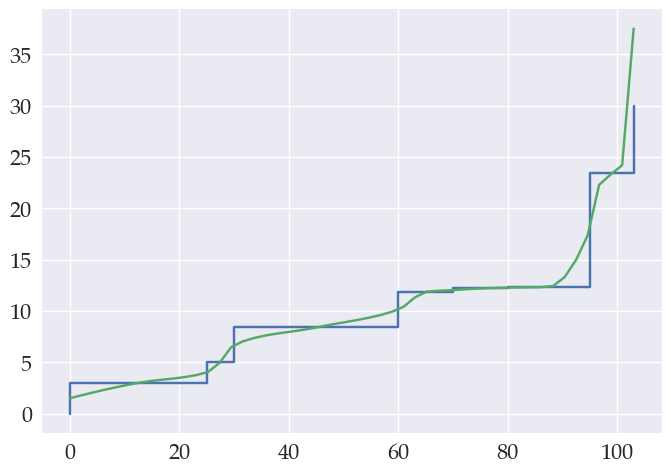

In [574]:
df_kink = kinked_supply(h=1,mc=m.db['mc'],production=m.hourlyGeneratingCapacity)
smooth_func = interpolate.PchipInterpolator(x=df_kink.index.values,y=df_kink.values,extrapolate=False)
d_smooth_func = smooth_func.derivative(1)
xvals = np.linspace(min(df_kink.index),max(df_kink.index),endpoint=True)
smooth_yvals = smooth_func(xvals)
plt.plot(supply_h(m,h=1))
plt.plot(xvals,smooth_yvals)

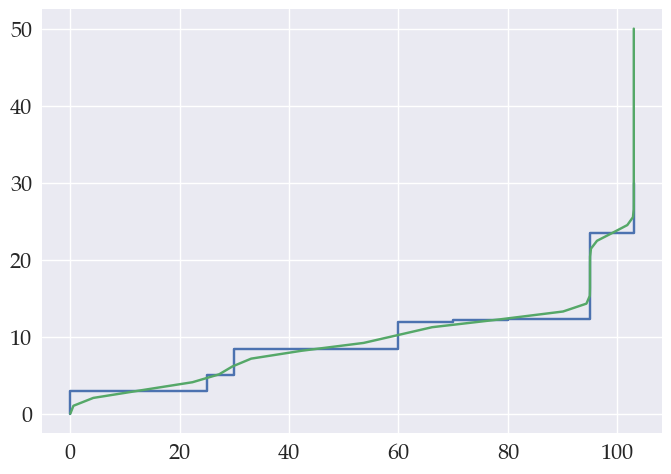

In [595]:
plt.plot(supply_h(m,h=1))
p_grid = np.linspace(0,m.db['MWP_LoadShedding']*2)
h=1 
mc = m.db['mc'].astype(float).sort_index().values
q = m.hourlyGeneratingCapacity.unstack('h').sort_index().astype(float).values
params = (mc,q,1)
S = [smooth_supply(p,*params)[0] for p in p_grid]
plt.plot(S,p_grid)
# plt.plot([d_smooth_supply(p,*params)[0] for p in p_grid],p_grid)

*Specify upper bound:*

In [14]:
def p_with_LoadShedding_0(x0,*params):
    x = x0
    pj,xj,μj,σ,I,S0 = params
    return(
        max_cap[0]-S0 - μj[0]*(x[0]/x[1])**(-σ)*I/x[1], # Endogenous p1
        x[2] - μj[1]*(pj[1]/x[1])**(-σ)*I/x[1], # Endogenous x2
        x[1] - (μj[0]*x[0]**(1-σ)+μj[1]*pj[1]**(1-σ))**(1/(1-σ)) # Endogenous price index
    )
def p_with_LoadShedding_1(x0,*params):
    x = x0
    pj,xj,μj,σ,I,S0 = params
    return(
        x[2] - μj[0]*(pj[0]/x[1])**(-σ)*I/x[1], # Endogenous x1
        max_cap[1]+(1-λ)*S0 - μj[1]*(x[0]/x[1])**(-σ)*I/x[1], # Endogenous p2
        x[1] - (μj[0]*pj[0]**(1-σ)+μj[1]*x[0]**(1-σ))**(1/(1-σ)) # Endogenous price index
    )
def p_with_LoadShedding_both(x0,*params):
    x = x0
    pj,xj,μj,σ,I,S0 = params
    return(
        max_cap[0]-S0 - μj[0]*(x[0]/x[2])**(-σ)*I/x[2], # Endogenous p1
        max_cap[1]+(1-λ)*S0- μj[1]*(x[1]/x[2])**(-σ)*I/x[2], # Endogenous p2
        x[2] - (μj[0]*x[0]**(1-σ)+μj[1]*x[1]**(1-σ))**(1/(1-σ)) # Endogenous price index
    )

*Specify iterative solution algorithm:*

In [55]:
def solve_with_flexible_demand(ϵ,max_iter,params): # ϵ is the absolute error allowed
    # Book-keeping
    n_iter = 0
    Obj = 10
    df_trace = pd.DataFrame()
    
    # Unpack parameters:
    μj,σ,I,S0 = params
    
    while (Obj>=ϵ) & (n_iter<=max_iter):      
        
        # b) Solve linear programming model:
        m.solve(printSol=False);

        # c) Get results from linear programming model:
        pj_LPmodel = m.db['marginalSystemCosts'].values
        Ej_LPmodel = m.db['HourlyDemand'].values - np.array([S0,-(1-λ)*S0])
        pj_tmp = pj_LPmodel.copy()
        
        # Update demand
        p = f_pCES(μj,pj_LPmodel,σ=σ) # Update price index
        Ej = v_qCES(μj=μj,pj=pj_LPmodel,p=p,σ=σ) # Update demand
        p_tmp, Ej_tmp = p.copy(), Ej.copy()
        
        # Check load shedding condition
        ls_cond = Ej>max_cap

        # d) Update demand
        if sum(ls_cond)>0:
            params_tmp = (pj_LPmodel,Ej_LPmodel,μj,σ,I,S0)
            if (ls_cond[0]==True) & (ls_cond[1]==False):
                Ej_tmp[0] = max_cap[0]-S0
                pj_tmp[0],p_tmp,Ej_tmp[1] = fsolve(p_with_LoadShedding_0, x0=[pj_LPmodel[0],p,Ej_LPmodel[1]], args=params_tmp)
            elif (ls_cond[1]==True) & (ls_cond[0]==False):
                Ej_tmp[1] = max_cap[1]+(1-λ)*S0
                pj_tmp[1],p_tmp,Ej_tmp[0] = fsolve(p_with_LoadShedding_1, x0=[pj_LPmodel[1],p,Ej_LPmodel[0]], args=params_tmp)
            else:
                Ej_tmp = max_cap - np.array([S0,-(1-λ)*S0])
                pj_tmp[0],pj_tmp[1],p = fsolve(p_with_LoadShedding_both, x0=[pj_LPmodel[0],pj_LPmodel[1],p], args=params_tmp)
        
        # Update book-keeping
        # df_trace.loc[n_iter,['E1','E2','E1_LP','E2_LP','p1_LP','p2_LP','p1_update','p2_update']] = np.concatenate((Ej,Ej_LPmodel,pj_LPmodel,pj_tmp))
        df_trace.loc[n_iter,['E1_LP','E2_LP','p1_LP','p2_LP','E1','E2','p1_update','p2_update','E1_update','E2_update']] = np.concatenate((Ej_LPmodel,pj_LPmodel,Ej,pj_tmp,Ej_tmp))

        # e) Check condition:
        # Obj = ((Ej[ls_cond]-m.db['HourlyDemand'].values[ls_cond])**2).sum()
        Obj = ((Ej_tmp-Ej_LPmodel)**2).sum()

        # d) Update parameters in linear programming model
        TotDemand = sum(Ej_tmp)+λ*S0
        m.db['Load'] = pd.Series([TotDemand],index=m.db['Load'].index,name='Load')
        m.db['HourlyDemand'] = pd.Series(Ej_tmp+np.array([S0,-(1-λ)*S0]),index=m.db['HourlyDemand'].index,name='HourlyDemand')
        m.db['LoadVariation'] = pd.Series(m.db['HourlyDemand'].values/m.db['Load'].sum(),index=m.db['LoadVariation'].index,name='LoadVariation')
        
        # Update number of iterations:
        n_iter += 1
    
    return {'m':m,'n_iterations':n_iter-1,'HourlyPrice':pj_LPmodel,'PriceIndex':p,'Demand':df_trace,'Obj':Obj}

*Solve model in nested for-loops:*

In [56]:
σ_grid = [0]#,0.5,1,1.5,10]
CES_param = {}
solution = {}
for σ in σ_grid:
       
    # Calibrate CES parameters by normalizing price index to 1:
    μj = Ej_ini*pj_ini**σ/I

    # Update flexible demand
    p = f_pCES(μj,pj_ini,σ=σ) # Update price index
    Ej = v_qCES(μj=μj,pj=pj_ini,p=p,σ=σ) # Update demand
#     
    # Update model
    m.db = db_base.copy()
    
    solution[σ] = {}
        
    for S0 in S0_grid:
        # Update demand from storage
        TotDemand = m.db['Load']+λ*S0
        m.db['Load'] = TotDemand
        m.db['HourlyDemand'] = m.db['HourlyDemand'] + [S0,-(1-λ)*S0]
        m.db['LoadVariation'] = pd.Series(m.db['HourlyDemand'].values/TotDemand.sum(),index=m.db['LoadVariation'].index,name='LoadVariation')
        
        # Solve model iteratively:
        if σ!='inelastic':
            solution[σ][S0] = solve_with_flexible_demand(ϵ=0.0001,max_iter=10,params=(μj,σ,I,S0));
        print('Finished')

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


*Check it is correct:*

In [57]:
max_cap

array([102.  ,  93.25])

In [58]:
[display(solution[0][i]['Demand']) for i in solution[0]]

E1_LP  E2_LP  p1_LP      p2_LP    E1    E2  p1_update  p2_update  \
0   22.0   88.0    3.0  23.443656  22.0  88.0        3.0  23.443656   

   E1_update  E2_update  
0       22.0       88.0

E1_LP      E2_LP     p1_LP      p2_LP         E1         E2  \
0   22.000000  88.000000  3.000000  12.346414  23.801389  95.205556   
1   23.801389  95.205556  5.031068  23.443656  21.547764  86.191056   
2   21.547764  86.191056  3.000000  12.346414  23.801389  95.205556   
3   23.801389  95.205556  5.031068  23.443656  21.547764  86.191056   
4   21.547764  86.191056  3.000000  12.346414  23.801389  95.205556   
5   23.801389  95.205556  5.031068  23.443656  21.547764  86.191056   
6   21.547764  86.191056  3.000000  12.346414  23.801389  95.205556   
7   23.801389  95.205556  5.031068  23.443656  21.547764  86.191056   
8   21.547764  86.191056  3.000000  12.346414  23.801389  95.205556   
9   23.801389  95.205556  5.031068  23.443656  21.547764  86.191056   
10  21.547764  86.191056  3.000000  12.346414  23.801389  95.205556   

    p1_update  p2_update  E1_update  E2_update  
0    3.000000  21.612579  23.801389  95.205556  
1    5.031068  23.443656  21.547764  86.191056  
2    3.000000  21.612579  23.801389  95.205556  
3    5.031068  23.443656  21.547764  86.191056  
4    3.000000  21.612579  23.801389  95.205556  
5    5.031068  23.443656  21.547764  86.191056  
6    3.000000  21.612579  23.801389  95.205556  
7    5.031068  23.443656  21.547764  86.191056  
8    3.000000  21.612579  23.801389  95.205556  
9    5.031068  23.443656  21.547764  86.191056  
10   3.000000  21.612579  23.801389  95.205556

E1_LP      E2_LP     p1_LP      p2_LP         E1         E2  \
0   26.245833  93.250000  8.393216  23.443656  20.838668  83.354673   
1   20.838668  83.354673  5.031068  12.346414  24.290278  97.161111   
2   24.290278  97.161111  5.031068  23.443656  21.547764  86.191056   
3   21.547764  86.191056  5.031068  12.346414  24.290278  97.161111   
4   24.290278  97.161111  5.031068  23.443656  21.547764  86.191056   
5   21.547764  86.191056  5.031068  12.346414  24.290278  97.161111   
6   24.290278  97.161111  5.031068  23.443656  21.547764  86.191056   
7   21.547764  86.191056  5.031068  12.346414  24.290278  97.161111   
8   24.290278  97.161111  5.031068  23.443656  21.547764  86.191056   
9   21.547764  86.191056  5.031068  12.346414  24.290278  97.161111   
10  24.290278  97.161111  5.031068  23.443656  21.547764  86.191056   

    p1_update  p2_update  E1_update  E2_update  
0    8.393216  23.443656  20.838668  83.354673  
1    5.031068  20.654721  24.290278  97.161111  
2    5.031068  23.443656  21.547764  86.191056  
3    5.031068  20.654721  24.290278  97.161111  
4    5.031068  23.443656  21.547764  86.191056  
5    5.031068  20.654721  24.290278  97.161111  
6    5.031068  23.443656  21.547764  86.191056  
7    5.031068  20.654721  24.290278  97.161111  
8    5.031068  23.443656  21.547764  86.191056  
9    5.031068  20.654721  24.290278  97.161111  
10   5.031068  23.443656  21.547764  86.191056

E1_LP      E2_LP     p1_LP      p2_LP         E1         E2  \
0   26.436653  82.279945  8.393216  12.346414  24.779167  99.116667   
1   24.779167  99.116667  8.393216  23.443656  20.838668  83.354673   
2   20.838668  83.354673  5.031068  12.346414  24.779167  99.116667   
3   24.779167  99.116667  8.393216  23.443656  20.838668  83.354673   
4   20.838668  83.354673  5.031068  12.346414  24.779167  99.116667   
5   24.779167  99.116667  8.393216  23.443656  20.838668  83.354673   
6   20.838668  83.354673  5.031068  12.346414  24.779167  99.116667   
7   24.779167  99.116667  8.393216  23.443656  20.838668  83.354673   
8   20.838668  83.354673  5.031068  12.346414  24.779167  99.116667   
9   24.779167  99.116667  8.393216  23.443656  20.838668  83.354673   
10  20.838668  83.354673  5.031068  12.346414  24.779167  99.116667   

    p1_update  p2_update  E1_update  E2_update  
0    8.393216  19.381855  24.779167  99.116667  
1    8.393216  23.443656  20.838668  83.354673  
2    5.031068  20.222392  24.779167  99.116667  
3    8.393216  23.443656  20.838668  83.354673  
4    5.031068  20.222392  24.779167  99.116667  
5    8.393216  23.443656  20.838668  83.354673  
6    5.031068  20.222392  24.779167  99.116667  
7    8.393216  23.443656  20.838668  83.354673  
8    5.031068  20.222392  24.779167  99.116667  
9    8.393216  23.443656  20.838668  83.354673  
10   5.031068  20.222392  24.779167  99.116667

E1_LP       E2_LP     p1_LP      p2_LP         E1          E2  \
0   32.112500   93.250000  8.393216  12.346414  25.268056  101.072222   
1   25.268056  101.072222  8.393216  23.443656  20.838668   83.354673   
2   20.838668   83.354673  8.393216  12.346414  25.268056  101.072222   
3   25.268056  101.072222  8.393216  23.443656  20.838668   83.354673   
4   20.838668   83.354673  8.393216  12.346414  25.268056  101.072222   
5   25.268056  101.072222  8.393216  23.443656  20.838668   83.354673   
6   20.838668   83.354673  8.393216  12.346414  25.268056  101.072222   
7   25.268056  101.072222  8.393216  23.443656  20.838668   83.354673   
8   20.838668   83.354673  8.393216  12.346414  25.268056  101.072222   
9   25.268056  101.072222  8.393216  23.443656  20.838668   83.354673   
10  20.838668   83.354673  8.393216  12.346414  25.268056  101.072222   

    p1_update  p2_update  E1_update   E2_update  
0    8.393216  18.966254  25.268056  101.072222  
1    8.393216  23.443656  20.838668   83.354673  
2    8.393216  18.966254  25.268056  101.072222  
3    8.393216  23.443656  20.838668   83.354673  
4    8.393216  18.966254  25.268056  101.072222  
5    8.393216  23.443656  20.838668   83.354673  
6    8.393216  18.966254  25.268056  101.072222  
7    8.393216  23.443656  20.838668   83.354673  
8    8.393216  18.966254  25.268056  101.072222  
9    8.393216  23.443656  20.838668   83.354673  
10   8.393216  18.966254  25.268056  101.072222

E1_LP       E2_LP     p1_LP      p2_LP         E1          E2  \
0   35.045833   93.250000  8.393216  12.346414  25.756944  103.027778   
1   25.756944  103.027778  8.393216  23.443656  20.838668   83.354673   
2   20.838668   83.354673  8.393216  12.346414  25.756944  103.027778   
3   25.756944  103.027778  8.393216  23.443656  20.838668   83.354673   
4   20.838668   83.354673  8.393216  12.346414  25.756944  103.027778   
5   25.756944  103.027778  8.393216  23.443656  20.838668   83.354673   
6   20.838668   83.354673  8.393216  12.346414  25.756944  103.027778   
7   25.756944  103.027778  8.393216  23.443656  20.838668   83.354673   
8   20.838668   83.354673  8.393216  12.346414  25.756944  103.027778   
9   25.756944  103.027778  8.393216  23.443656  20.838668   83.354673   
10  20.838668   83.354673  8.393216  12.346414  25.756944  103.027778   

    p1_update  p2_update  E1_update   E2_update  
0    8.393216  18.566431  25.756944  103.027778  
1    8.393216  23.443656  20.838668   83.354673  
2    8.393216  18.566431  25.756944  103.027778  
3    8.393216  23.443656  20.838668   83.354673  
4    8.393216  18.566431  25.756944  103.027778  
5    8.393216  23.443656  20.838668   83.354673  
6    8.393216  18.566431  25.756944  103.027778  
7    8.393216  23.443656  20.838668   83.354673  
8    8.393216  18.566431  25.756944  103.027778  
9    8.393216  23.443656  20.838668   83.354673  
10   8.393216  18.566431  25.756944  103.027778

E1_LP       E2_LP     p1_LP      p2_LP         E1          E2  \
0   37.979167   93.250000  8.393216  12.346414  26.245833  104.983333   
1   26.245833  104.983333  8.393216  23.443656  20.838668   83.354673   
2   20.838668   83.354673  8.393216  12.346414  26.245833  104.983333   
3   26.245833  104.983333  8.393216  23.443656  20.838668   83.354673   
4   20.838668   83.354673  8.393216  12.346414  26.245833  104.983333   
5   26.245833  104.983333  8.393216  23.443656  20.838668   83.354673   
6   20.838668   83.354673  8.393216  12.346414  26.245833  104.983333   
7   26.245833  104.983333  8.393216  23.443656  20.838668   83.354673   
8   20.838668   83.354673  8.393216  12.346414  26.245833  104.983333   
9   26.245833  104.983333  8.393216  23.443656  20.838668   83.354673   
10  20.838668   83.354673  8.393216  12.346414  26.245833  104.983333   

    p1_update  p2_update  E1_update   E2_update  
0    8.393216  18.181503  26.245833  104.983333  
1    8.393216  23.443656  20.838668   83.354673  
2    8.393216  18.181503  26.245833  104.983333  
3    8.393216  23.443656  20.838668   83.354673  
4    8.393216  18.181503  26.245833  104.983333  
5    8.393216  23.443656  20.838668   83.354673  
6    8.393216  18.181503  26.245833  104.983333  
7    8.393216  23.443656  20.838668   83.354673  
8    8.393216  18.181503  26.245833  104.983333  
9    8.393216  23.443656  20.838668   83.354673  
10   8.393216  18.181503  26.245833  104.983333

E1_LP       E2_LP     p1_LP      p2_LP         E1          E2  \
0   40.912500   93.250000  8.393216  12.346414  26.734722  106.938889   
1   26.734722  106.938889  8.393216  23.443656  20.838668   83.354673   
2   20.838668   83.354673  8.393216  12.193476  26.734722  106.938889   
3   26.734722  106.938889  8.393216  23.443656  20.838668   83.354673   
4   20.838668   83.354673  8.393216  12.193476  26.734722  106.938889   
5   26.734722  106.938889  8.393216  23.443656  20.838668   83.354673   
6   20.838668   83.354673  8.393216  12.193476  26.734722  106.938889   
7   26.734722  106.938889  8.393216  23.443656  20.838668   83.354673   
8   20.838668   83.354673  8.393216  12.193476  26.734722  106.938889   
9   26.734722  106.938889  8.393216  23.443656  20.838668   83.354673   
10  20.838668   83.354673  8.393216  12.193476  26.734722  106.938889   

    p1_update  p2_update  E1_update   E2_update  
0    8.393216  17.810653  26.734722  106.938889  
1    8.393216  23.443656  20.838668   83.354673  
2    8.393216  17.810653  26.734722  106.938889  
3    8.393216  23.443656  20.838668   83.354673  
4    8.393216  17.810653  26.734722  106.938889  
5    8.393216  23.443656  20.838668   83.354673  
6    8.393216  17.810653  26.734722  106.938889  
7    8.393216  23.443656  20.838668   83.354673  
8    8.393216  17.810653  26.734722  106.938889  
9    8.393216  23.443656  20.838668   83.354673  
10   8.393216  17.810653  26.734722  106.938889

E1_LP       E2_LP      p1_LP      p2_LP         E1          E2  \
0   43.845833   93.250000  11.872521  12.346414  27.223611  108.894444   
1   27.223611  108.894444   8.393216  23.443656  20.838668   83.354673   
2   20.838668   83.354673   8.393216  12.193476  27.223611  108.894444   
3   27.223611  108.894444   8.393216  23.443656  20.838668   83.354673   
4   20.838668   83.354673   8.393216  12.193476  27.223611  108.894444   
5   27.223611  108.894444   8.393216  23.443656  20.838668   83.354673   
6   20.838668   83.354673   8.393216  12.193476  27.223611  108.894444   
7   27.223611  108.894444   8.393216  23.443656  20.838668   83.354673   
8   20.838668   83.354673   8.393216  12.193476  27.223611  108.894444   
9   27.223611  108.894444   8.393216  23.443656  20.838668   83.354673   
10  20.838668   83.354673   8.393216  12.193476  27.223611  108.894444   

    p1_update  p2_update  E1_update   E2_update  
0   11.872521  16.583296  27.223611  108.894444  
1    8.393216  23.443656  20.838668   83.354673  
2    8.393216  17.453122  27.223611  108.894444  
3    8.393216  23.443656  20.838668   83.354673  
4    8.393216  17.453122  27.223611  108.894444  
5    8.393216  23.443656  20.838668   83.354673  
6    8.393216  17.453122  27.223611  108.894444  
7    8.393216  23.443656  20.838668   83.354673  
8    8.393216  17.453122  27.223611  108.894444  
9    8.393216  23.443656  20.838668   83.354673  
10   8.393216  17.453122  27.223611  108.894444

E1_LP       E2_LP      p1_LP      p2_LP         E1          E2  \
0   46.779167   93.250000  11.872521  12.346414  27.712500  110.850000   
1   27.712500  110.850000   8.393216  23.443656  20.838668   83.354673   
2   20.838668   83.354673   8.393216  12.193476  27.712500  110.850000   
3   27.712500  110.850000   8.393216  23.443656  20.838668   83.354673   
4   20.838668   83.354673   8.393216  12.193476  27.712500  110.850000   
5   27.712500  110.850000   8.393216  23.443656  20.838668   83.354673   
6   20.838668   83.354673   8.393216  12.193476  27.712500  110.850000   
7   27.712500  110.850000   8.393216  23.443656  20.838668   83.354673   
8   20.838668   83.354673   8.393216  12.193476  27.712500  110.850000   
9   27.712500  110.850000   8.393216  23.443656  20.838668   83.354673   
10  20.838668   83.354673   8.393216  12.193476  27.712500  110.850000   

    p1_update  p2_update  E1_update   E2_update  
0   11.872521  16.238381  27.712500  110.850000  
1    8.393216  23.443656  20.838668   83.354673  
2    8.393216  17.108207  27.712500  110.850000  
3    8.393216  23.443656  20.838668   83.354673  
4    8.393216  17.108207  27.712500  110.850000  
5    8.393216  23.443656  20.838668   83.354673  
6    8.393216  17.108207  27.712500  110.850000  
7    8.393216  23.443656  20.838668   83.354673  
8    8.393216  17.108207  27.712500  110.850000  
9    8.393216  23.443656  20.838668   83.354673  
10   8.393216  17.108207  27.712500  110.850000

[None, None, None, None, None, None, None, None, None, None]

#### 4.1. *Simulate experiment:*

To create the simulation, we use the ```loopSolveExtract``` method that we also used in [Exercise 1](E1_SolutionGuide.ipynb):

i) Create loop (with 51 gridpoints here):

iii) Specify which symbols to save in the simulations:

In [ ]:
extract = ['Generation','marginalEconomicValue','marginalSystemCosts','LoadVariation','HourlyDemand','Welfare']

iv) Run simulation:

In [ ]:
solution = m.loopSolveExtract(loop,[LoadVariationGrid],extract)

*Plot prices:*

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
solution['marginalSystemCosts'].unstack('h').plot(ax=ax,legend=False)
(solution['marginalSystemCosts']*solution['LoadVariation']).groupby('loop').agg('sum').plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.legend(['Off-peak', 'Peak', 'Price index'],loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot marginal values:*

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
solution['marginalEconomicValue'][('id7',)].plot(ax=ax,legend=False)
# solution['marginalEconomicValue'].unstack('id').plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);
# fig.legend(['Off-peak', 'Peak', 'Price index'],loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot practical capacity factor:*

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df = (solution['Generation'].xs('id7',level='id')/db['CapVariation'].xs('Wind',level='hvt')/2/db['GeneratingCapacity']['id7']).groupby('loop').agg('sum')
df.plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot profits:*

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
(solution['marginalEconomicValue'][('id7',)]*df).plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot welfare:*

In [ ]:
# Producers
p = solution['marginalSystemCosts']
E = solution['Generation']
R = p*E
mc = db['mc']
VC = mc*E
fom = db['FOM']*1000*len(db['h'])/8760
FOM = fom*db['GeneratingCapacity']
id2tech = {x[0]:x[1] for x in db['id2tech']}
Π = (R-VC-FOM).groupby(['loop','id']).agg('sum').rename(id2tech,level='id').groupby(['loop','id']).agg('sum').rename_axis(['loop','agent']).rename('W')

# Consumers
Δp = db['MWP_LoadShedding']-p
S0 = (step.cumsum()*db['Load']).astype(float).droplevel('c')
L = solution['HourlyDemand']-S0
v = (Δp*L).groupby('loop').agg('sum').to_frame().assign(agent='Consumer').set_index('agent',append=True)[0].rename('W')

# Storage
π = p.unstack('h')
π['diff'] = (1-λ)*π[2]-π[1]
π = (π['diff']*S0.droplevel('h')).to_frame().assign(agent='Storage').set_index('agent',append=True)[0].rename('W')
# Combine dataframe
W = Π.append(v).append(π).sort_index()
W_neg, W_pos = W.groupby('agent').diff().clip(upper=0).unstack('agent').fillna(0), W.groupby('agent').diff().clip(lower=0).unstack('agent').fillna(0)

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
W_pos.plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
ax.set_prop_cycle(None)
W_neg.rename(columns=lambda x: '_' + x).plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
W.groupby('loop').agg('sum').diff().fillna(0).reset_index().plot.scatter(ax=ax,x='loop',y='W',color='black',s=35,marker='o')

# Axes
ax.set_ylim([W_neg.sum(axis=1).min()*1.5, W_pos.sum(axis=1).max()*1.1])
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10)
ax.set_ylabel(r'$€$',labelpad=5)

# General
legend_elements = [mpl.lines.Line2D([0], [0], marker='o',color='w', label='Net effect',markerfacecolor='black', markersize=10),
                   mpl.patches.Patch(facecolor=colors[4], edgecolor=None, label='Wind'),
                   mpl.patches.Patch(facecolor=colors[3], edgecolor=None, label='Storage'),
                   mpl.patches.Patch(facecolor=colors[2], edgecolor=None, label='Standard'),
                   mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='Solar PV'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='Consumer')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);